# HowTo - 3 - Get offset stars and make finding charts

# 0) Load test data
### We begin again by loading the modules and the test data

In [1]:
import pandas as pd
from qso_toolbox import catalog_tools as ct, image_tools as it

pd.options.mode.chained_assignment = None

In [2]:
df_hdf = pd.read_hdf('./data/stripe82_milliquas_190210.hdf5',key='data')

# We use the first 10 entries of the test set we used for HowTo-1-DownloadingImageCutouts
test_set = df_hdf.query('340 < mq_ra < 350 and -1.26 < mq_dec < 0')[:10]

test_set

,mq_ra,mq_dec,mq_name,mq_z,mq_cite
29552,340.029741,-0.892448,PGC 1132088,0.054,PGC
29553,340.032899,-1.256140,SDSS J224007.89-011522.1,0.659,DR14Q
29554,340.039043,-0.649055,SDSS J224009.37-003856.5,2.306,DR14Q
29556,340.047792,-1.246840,SDSS J224011.46-011448.6,1.451,DR14Q
29557,340.055801,-0.901223,SDSS J224013.39-005404.4,0.160,DR14
29559,340.059501,-0.189209,SDSS J224014.28-001121.1,2.235,DR14
29561,340.072023,-1.245235,SDSS J224017.28-011442.8,0.502,DR14Q
29562,340.076227,-0.873265,SDSS J224018.29-005223.7,2.561,DR14Q
29563,340.077436,-0.115803,SDSS J224018.58-000656.8,2.297,DR14Q
29567,340.094890,-0.031102,SDSS J224022.77-000151.9,0.910,DR14Q


# 1) Get offset stars 

### The main routines to get offset stars are found in catalog_tools. The routines use the astroquery package (get_astroquery_offset), the NOAO datalab python package (get_offset_stars_datalab) and the MAST website for PanSTARRS (get_offset_stars_ps1). Due to the way that different surveys scripted region queries, this seemed to be the most comfortable way of coding it up at this time. In the future one would want to consolidate these into one function.

### For each object in the supplied dataframe the function calls a region query around the object. The closest 'n' objects (fulfilling all specified criteria) are retrieved and stored in a new dataframe. After each object the new dataframe is stored in 'temp_offset_df.csv' in case one region query fails. In the end all functions return a dataframe with a maximum of 'n' offset starts per object.

### The dataframe includes the original target name, RA and Dec, the offset name (including its suffix), offset Ra and Dec, one magnitude for the offset, the separation (arcseconds), position angle, Ra and Dec offset (arcseconds).

### The offset stars in the dataframe will be given alphabetical suffices (e.g. '_A',' _B', etc.). Currently retrieval of a maximum of n=5 offset stars is possible.

### All offset star routines use essentially three different functions. 
### a) query_region_"astroquery, ps1, datalab"()
    Returns the catalog data of sources within a given radius of a defined
    position.
### b) get_"astroquery, ps1, datalab"_offset()
    Return the n nearest offset stars specified by the quality criteria
    around a given target.
### c) get_offset_stars_"astroquery, ps1, datalab"()
    Get offset stars for all targets in the input DataFrame.
    
### While one would usually use function c) to retrieve offset stars, functions a) and b) can also be used indepdently from c).




# 1.1) Astroquery offsets

### Currently options to get offset stars from 2MASS, NOMAD and VHSDR6 using the IRSA, Vizier and VSA astroquery services. It is trivial to add more surveys for these three services.

### These surveys are summarized in the internal variable astroquery_dict. Please have a look into the dictionary as it also sets, which magnitude will be retrieved.

    astroquery_dict = {
                        'tmass': {'service': 'irsa', 'catalog': 'fp_psc',
                                  'ra': 'ra', 'dec': 'dec', 'mag_name':
                                  'TMASS_J', 'mag': 'j_m', 'distance':
                                  'dist', 'data_release': None},
                        'nomad': {'service': 'vizier', 'catalog': 'NOMAD',
                                  'ra': 'RAJ2000', 'dec': 'DECJ2000',
                                  'mag_name': 'R', 'mag': 'Rmag', 'distance':
                                  'distance', 'data_release': None},
                        'vhsdr6': {'service': 'vsa', 'catalog': 'VHS',
                                   'ra': 'ra', 'dec': 'dec',
                                   'data_release': 'VHSDR6', 'mag_name': 'VHS_J',
                                   'mag': 'jAperMag3', 'distance': 'distance'}
                      }

## Example:
### We will retrieve offset stars for the test_set from VHS DR6. It will automatically retrieve the J-band magnitude ('jAperMag3') along with the position. The additional quality query ensures that we do not retrieve the target itself, limits the objects to a certain J-band magnitude range and set a simple quality flag for the J-band.

In [3]:
# Quality query needs to be written in pandas dataframe query syntax. Knowledge about the
# catalog columns returned from the query_region_astroquery() function is very useful.
quality_query = 'distance > 3/60. and 10 < jAperMag3 < 20 and jppErrBits==0'

offset_df = ct.get_offset_stars_astroquery(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, catalog='vhsdr6',
                                quality_query=quality_query, n=3, verbosity=2)



Offset delta ra: [-0.0012114  -0.00040132  0.00191181] deg
Offset delta dec: [-0.0024384   0.00320341  0.00278962] deg
Offset separation: [ 9.80182575 11.62241203 12.17468909] arcsec
Offset position angle: [206.41818948 352.85932736  34.42399807] deg
Offset delta ra: [ 0.00286052 -0.00470989 -0.01206559] deg
Offset delta dec: [-0.01137324  0.01193596  0.00623136] deg
Offset separation: [42.21882191 46.1937797  48.8869169 ] arcsec
Offset position angle: [165.88216324 338.46596684 297.31441355] deg
Offset delta ra: [-0.00060836 -0.00272547  0.00475394] deg
Offset delta dec: [-0.0023313   0.00393553 -0.00105412] deg
Offset separation: [ 8.67372452 17.233663   17.52987369] arcsec
Offset position angle: [194.62545674 325.29624938 102.50224451] deg
Offset delta ra: [ 0.00520252 -0.00726854 -0.00950033] deg
Offset delta dec: [-0.00208068  0.00166241 -0.00377397] deg
Offset separation: [20.17138815 26.84241995 36.80095172] arcsec
Offset position angle: [111.79833477 282.88271637 248.3347299 ] 

### Let's display (a few rows from) the offset dataframe:

In [4]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,jAperMag3,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.030953,-0.890009,19.633066,9.801826,206.418189,-4.361024,-8.778227
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.030142,-0.895651,19.439920,11.622412,352.859327,-1.444734,11.532268
2,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_C,PGC 1132088_offset_C,340.027829,-0.895237,19.562323,12.174689,34.423998,6.882505,10.042618
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.030038,-1.244767,19.275267,42.218822,165.882163,10.297886,-40.943650
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.037610,-1.268076,17.606583,46.193780,338.465967,-16.955604,42.969440


# 1.2) Datalab offsets

### The datalab version offers access to a different range of surveys than astroquery. At this point only access to DES DR1 data is included here. Similar to the astroquery routines a simple dictionary sets this limitation an can be easily expanded. The current dictionary reads:

    datalab_offset_dict = {'des_dr1.main': {'ra': 'ra', 'dec': 'dec',
                                          'mag': 'mag_auto_z',
                                          'mag_name': 'mag_auto_z'}}
                                          
### Main difference to the astroquery offset routines:  The 'quality_query' keyword argument is replaced by 'where', which is now in ADQL (Astronomical Data Query Language) syntax.
                                          
## Example:
### We will again provide a quick example. 

In [5]:
# The where keyword argument will be added to the ADQL query to the NOAO datalab.
where = 'mag_auto_z > 15 AND mag_auto_z < 19'

offset_df = ct.get_offset_stars_datalab(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, survey='des_dr1', table='main',
                             n=3, where=where, verbosity=2)

SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.029741, -0.8924476999999998) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.029741, -0.8924476999999998, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19
Offset delta ra: [0.00010499 0.01518616] deg
Offset delta dec: [-0.0041647   0.00690527] deg
Offset separation: [14.99768314 60.05660193] arcsec
Offset position angle: [178.55594561  65.54832375] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.03289900000004, -1.25614) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.03289900000004, -1.25614, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19
Offset delta ra: [-0.00471587 -0.01311885  0.01235603] deg
Offset delta dec: [0.011926   0.00489497 0.01257997] deg
Offset separation: [46.16833616 50.40833555 63.47925417] arcsec
Offset position angle: [338.42479597 290.46179221  44.48546263] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.039043, -0.6490545999999999) as distance FROM des_dr1.main WHERE q3c_radial_query(ra

### Let's display (a few rows from) the offset dataframe:

In [6]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,mag_auto_z,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.029636,-0.888283,18.5337,14.997683,178.555946,0.377954,-14.992920
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.014553,-0.899353,17.8420,60.056602,65.548324,54.670168,24.858966
2,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.037616,-1.268066,18.2898,46.168336,338.424796,-16.977120,42.933585
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.046021,-1.261035,16.7347,50.408336,290.461792,-47.227848,17.621881
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_C,SDSS J224007.89-011522.1_offset_C,340.020540,-1.268720,17.6612,63.479254,44.485463,44.481709,45.287894


# 1.3) PanSTARRS offsets

### The PanSTARRS version of the offset query uses the MAST website to query the archive using a url and retrieving the provided data table. 
### The 'qualiy_query' keyword argument in pandas query syntax then applies quality criteria to the retrieved data table.

### WARNING: As the response from the MAST PanSTARRS archive is slow the routine will take a while for large target catalogs.

## Example:

In [7]:
quality_query = '10 < zMeanPSFMag < 19'

offset_df = ct.get_offset_stars_ps1(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, data_release='dr2',
                     catalog='mean', quality_query=quality_query, verbosity=2)

Querying PS1 Archive (mean,dr2) for PGC 1132088
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.029741&dec=-0.8924476999999998&radius=0.025&format=csv
Offset delta ra: [1.45982289e-06 2.37774153e-03 3.02893253e-03] deg
Offset delta dec: [-2.69500000e-05  9.25969231e-04 -5.95621246e-04] deg
Offset separation: [ 0.09716223  9.1860501  11.11298305] arcsec
Offset position angle: [176.89944231  68.722457   101.1249217 ] deg
Querying PS1 Archive (mean,dr2) for SDSS J224007.89-011522.1
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.03289900000004&dec=-1.25614&radius=0.025&format=csv
Offset delta ra: [ 0.00452541 -0.0008971  -0.01315972] deg
Offset delta dec: [0.01307324 0.01382722 0.00491608] deg
Offset separation: [49.80361017 49.8826482  50.57275542] arcsec
Offset position angle: [ 19.09373193 356.28787598 290.48418512] deg
Querying PS1 Archive (mean,dr2) for SDSS J224009.37-003856.5
Opening https://catalogs.mast.stsci.edu/api/v0.1/pans

### Let's display (a few rows from) the offset dataframe:

In [8]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,ps1_dr2_mean_psfmag_y,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.029740,-0.892421,16.2442,0.097162,176.899442,0.005255,-0.097020
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.027363,-0.893374,-999.0000,9.186050,68.722457,8.559870,3.333489
2,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_C,PGC 1132088_offset_C,340.026712,-0.891852,-999.0000,11.112983,101.124922,10.904157,-2.144236
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.028372,-1.269213,-999.0000,49.803610,19.093732,16.291484,47.063650
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.033796,-1.269967,-999.0000,49.882648,356.287876,-3.229576,49.777991


# 2) Get Finding Charts

### The qso_toolbox image_tools package also provides routines for finding chart generation. However, before finding charts can be made the images need to be downloaded and, if necessary, offset stars need to be found.

### The following example downloads the images and retrives offset starts for our test set:

In [9]:
# Download finding chart images 
surveys = ['vhsdr6']
bands = ['J']
fovs = [300]

ct.get_photometry(test_set, 'mq_ra', 'mq_dec', surveys, bands, './cutouts/', fovs, verbosity=0)


# Get offset stars
quality_query = 'distance > 3/60. and 10 < jAperMag3 < 20 and jppErrBits==0'

offset_df = ct.get_offset_stars_astroquery(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, catalog='vhsdr6',
                                quality_query=quality_query, n=3, verbosity=0)



### Now we are ready to produce finding charts. The routine that you probably want to use is image_tools.make_finding_charts(). It generates finding charts for the entire target list (pandas dataframe) and saves them either in png or pdf format.

### Before we demonstrate this routine, we will show how you generate only one finding chart in the following example:

                target_name   target_ra  target_dec  \
0  SDSS J224007.89-011522.1  340.032899    -1.25614   
1  SDSS J224007.89-011522.1  340.032899    -1.25614   
2  SDSS J224007.89-011522.1  340.032899    -1.25614   

                         offset_name                   offset_shortname  \
0  SDSS J224007.89-011522.1_offset_A  SDSS J224007.89-011522.1_offset_A   
1  SDSS J224007.89-011522.1_offset_B  SDSS J224007.89-011522.1_offset_B   
2  SDSS J224007.89-011522.1_offset_C  SDSS J224007.89-011522.1_offset_C   

    offset_ra  offset_dec  jAperMag3  separation   pos_angle  dra_offset  \
0  340.030038   -1.244767  19.275267   42.218822  165.882163   10.297886   
1  340.037610   -1.268076  17.606583   46.193780  338.465967  -16.955604   
2  340.044967   -1.262371  19.048584   48.886917  297.314414  -43.436115   

   ddec_offset  
0    -40.94365  
1     42.96944  
2     22.43289  
340.03289900000004 -1.25614
Opened ./cutouts/J224007.90-011522.10_vhsdr6_J_fov120.fits with a fov of 120 

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

[INFO] Generating offsets for ./cutouts//J224007.90-011522.10_vhsdr6_J*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/

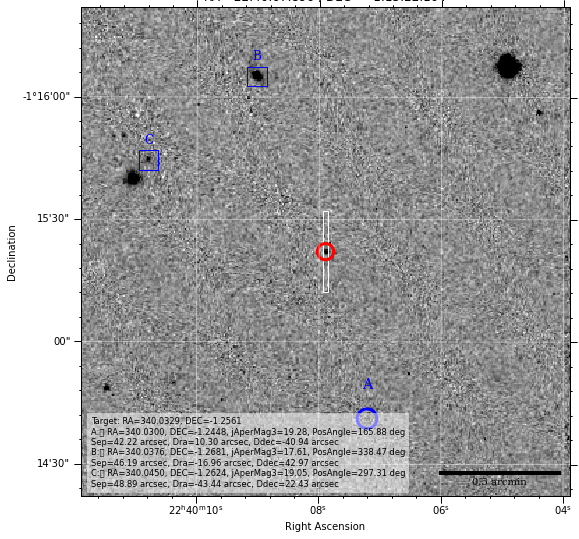

In [10]:
# We first reduce the offsets in the catalog to the ones for this particular target 
offset_target = offset_df.query('target_name=="{}"'.format('SDSS J224007.89-011522.1'))
offset_target.reset_index(inplace=True, drop=True)
print(offset_target)
# Make one finding chart 
ra = test_set.loc[test_set.index[1],'mq_ra']
dec = test_set.loc[test_set.index[1],'mq_dec']
print(ra, dec)
it.make_finding_chart(ra, dec, 'vhsdr6', 'J', 2, 120,
                        './cutouts/',
                        offset_df=offset_target,
                        offset_ra_column_name='offset_ra',
                        offset_dec_column_name='offset_dec',
                        offset_mag_column_name='jAperMag3',
                        offset_id_column_name='offset_name',
                        slit_width=1.0, slit_length=20,
                        position_angle=0, verbosity=2)

### Generating finding charts for your entire target catalog is comparatively easy. You just call the function below supplied with your target catalog and the offset star catalog.

                 target_name   target_ra  target_dec  \
0                PGC 1132088  340.029741   -0.892448   
1                PGC 1132088  340.029741   -0.892448   
2                PGC 1132088  340.029741   -0.892448   
3   SDSS J224007.89-011522.1  340.032899   -1.256140   
4   SDSS J224007.89-011522.1  340.032899   -1.256140   
5   SDSS J224007.89-011522.1  340.032899   -1.256140   
6   SDSS J224009.37-003856.5  340.039043   -0.649055   
7   SDSS J224009.37-003856.5  340.039043   -0.649055   
8   SDSS J224009.37-003856.5  340.039043   -0.649055   
9   SDSS J224011.46-011448.6  340.047792   -1.246840   
10  SDSS J224011.46-011448.6  340.047792   -1.246840   
11  SDSS J224011.46-011448.6  340.047792   -1.246840   
12  SDSS J224013.39-005404.4  340.055801   -0.901223   
13  SDSS J224013.39-005404.4  340.055801   -0.901223   
14  SDSS J224013.39-005404.4  340.055801   -0.901223   
15  SDSS J224014.28-001121.1  340.059501   -0.189209   
16  SDSS J224014.28-001121.1  340.059501   -0.18

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224007.14-005332.81_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_PGC 1132088 created


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224007.90-011522.10_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warning

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224007.89-011522.1 created


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224009.37-003856.60_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in

/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224009.37-003856.5 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224011.47-011448.62_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in

/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224011.46-011448.6 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224013.39-005404.40_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in

/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224013.39-005404.4 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224014.28-001121.15_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224014.28-001121.1 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224017.29-011442.85_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224017.28-011442.8 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224018.29-005223.75_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().

/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


fc_SDSS J224018.29-005223.7 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Mat

Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed

[INFO] Generating offsets for ./cutouts/J224018.58-000656.89_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw

fc_SDSS J224018.58-000656.8 created
HTTP Error 502: Proxy Error


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


Exception encountered: local variable 'fit' referenced before assignment
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
[INFO] Generating offsets for ./cutouts/J224022.77-000151.97_desdr1_z*.fits


/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.7/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warning

/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schin

fc_SDSS J224022.77-000151.9 created


/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


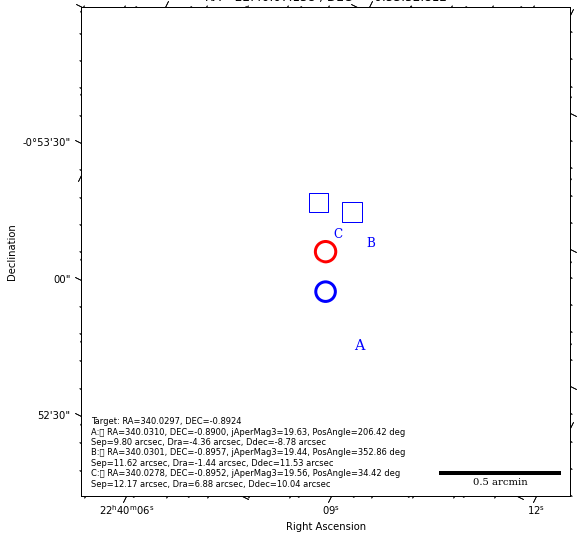

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

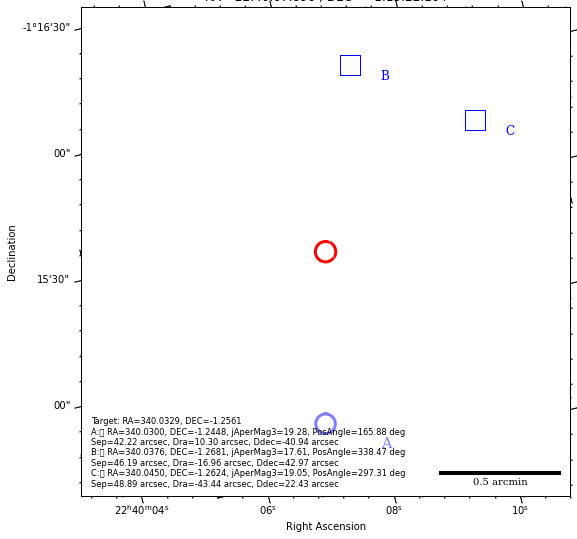

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

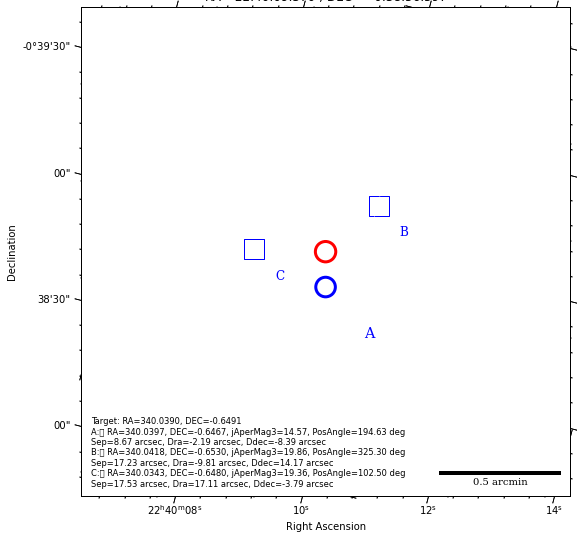

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

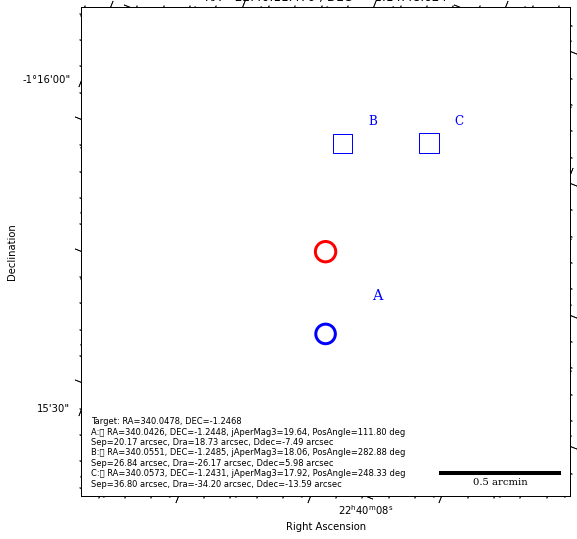

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

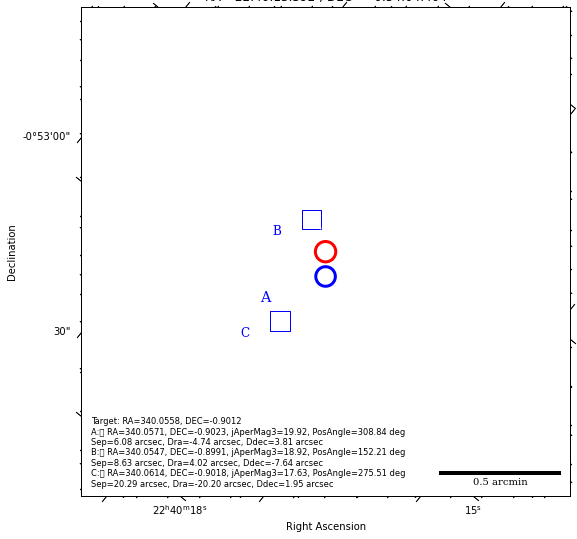

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

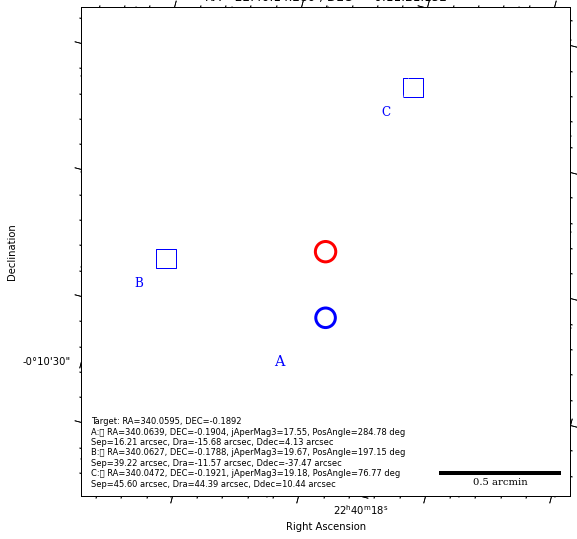

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

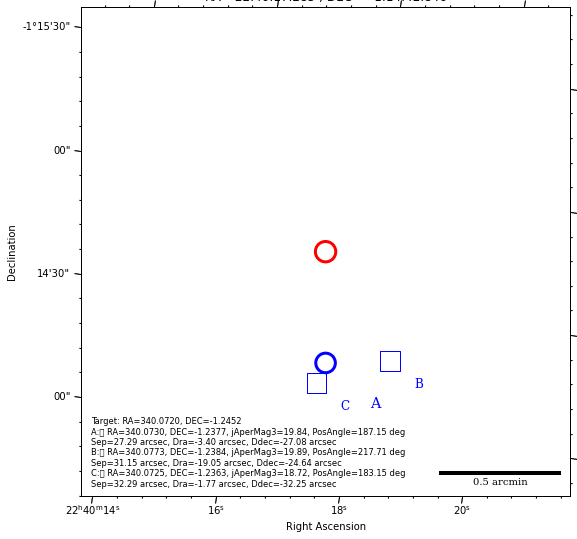

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

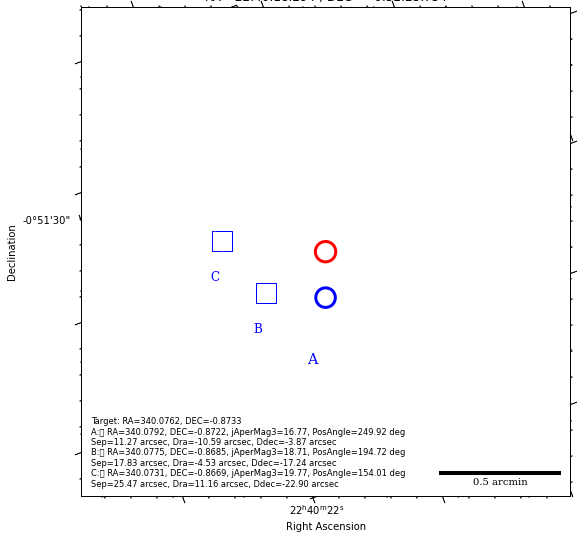

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

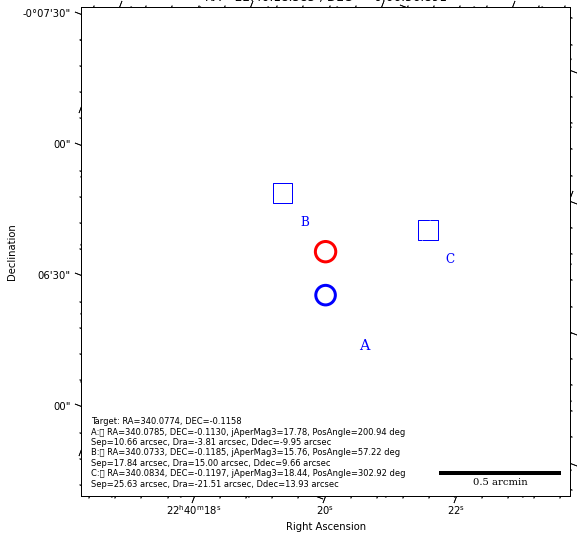

/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/schindler/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/schindler/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3

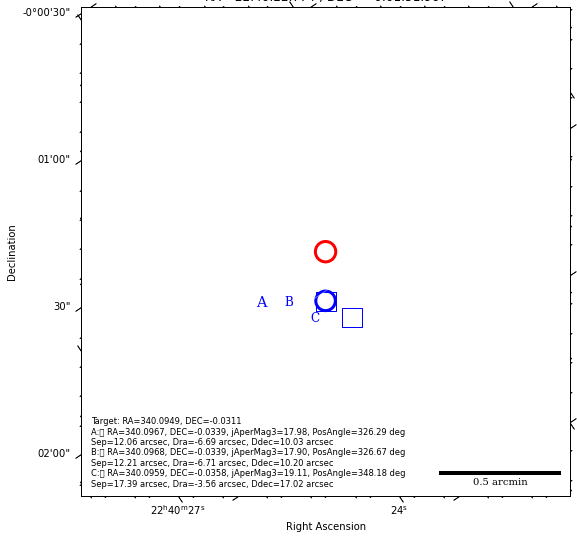

In [11]:
# Make finding charts
it.make_finding_charts(test_set, 'mq_ra', 'mq_dec',
                        'mq_name', 'desdr1', 'z',
                        2.5, 120, './cutouts',
                        offset_table=offset_df,
                        offset_focus=False,
                        offset_ra_column_name='offset_ra',
                        offset_dec_column_name='offset_dec',
                        pos_angle_column_name=None,
                        offset_mag_column_name='jAperMag3',
                        offset_id_column_name='offset_shortname',
                        label_position='topleft',
                        slit_width=1.0, slit_length=50,
                        format='png', verbosity=0, 
                      auto_download=True)

### In the end make sure that your finding charts reflect the depth, sensitivity and field of view of your acquisition camera. So you will likely need to tweak the code here and there.
### In addition, make sure to check all finding charts! If you take a look at the once we generated you will notice that a few extended sources are selected as offset stars. This should not be the case, so make sure to include the necessary quality criteria when you retrieve offset stars.